# Implementing SVD To Build a Subreddit Recommendation Engine

We're going to be implementing an SVD model to build a subreddit recommendation engine.

In this notebook, I'll go through the process of actually building the engine itself, after having previously collected reddit comment data.

The source for this code is here: https://beckernick.github.io/matrix-factorization-recommender/

In [1]:
# First let's load some packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sqlite3

In [2]:
# and now we'll load in the comment data

conn = sqlite3.Connection("./reddit_rec_data.sqlite")
data = pd.read_sql("SELECT * FROM comment_data", con=conn)
data.rename(columns={'variable': 'subreddit', 'value': 'comments'}, inplace=True)

In [3]:
data.head()

,index,user,subreddit,comments
0,0,DCbean,r/10cloverfieldlane,1.0
1,1,fakedeepusername,r/1200isplenty,4.0
2,2,Shyguy380,r/13ReasonsWhy,1.0
3,3,jamjax12,r/13ReasonsWhy,5.0
4,4,Death215,r/2007scape,2.0


In [4]:
# now we need to pivot the data to be able to get it so each row is a user, and the columns are subreddits.
# let's start with just a sample of the data

sample = data.iloc[0:50000, :]
R_df = sample.pivot(index='user', columns='subreddit', values='comments').fillna(0)

In [6]:
R_df.head()

subreddit,r/0xProject,r/100ballshack,r/100yearsago,r/1022,r/10cloverfieldlane,r/10mm,r/1200isjerky,r/1200isplenty,r/12Monkeys,r/13ReasonsWhy,...,r/zyzz,u/Cazazkq,u/Nintendo_America,u/OfficialValKilmer,u/Python422,u/Shitty_Watercolour,u/SmilsumKcuf,u/_BindersFullOfWomen_,u/maximumcrisis,u/washingtonpost
user,,,,,,,,,,,,,,,,,,,,,
--ManBearPig--,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-Agathia-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-Big_Bad-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-Chrown-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-Claive-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# Now we need to "de-mean" the ratings, that is subtract the mean # of comments from each users number of comments

R = R_df.as_matrix()
R_means = np.mean(R, axis = 1)
R_demeaned = R - R_means.reshape(-1,1)

In [11]:
R_demeaned

array([[-0.00325648, -0.00325648, -0.00325648, ..., -0.00325648,
        -0.00325648, -0.00325648],
       [-0.00143285, -0.00143285, -0.00143285, ..., -0.00143285,
        -0.00143285, -0.00143285],
       [-0.00325648, -0.00325648, -0.00325648, ..., -0.00325648,
        -0.00325648, -0.00325648],
       ..., 
       [-0.00325648, -0.00325648, -0.00325648, ..., -0.00325648,
        -0.00325648, -0.00325648],
       [-0.00325648, -0.00325648, -0.00325648, ..., -0.00325648,
        -0.00325648, -0.00325648],
       [-0.00156311, -0.00156311, -0.00156311, ..., -0.00156311,
        -0.00156311, -0.00156311]])

# SVD

Now that we have properly normalized data we can do the SVD modeling

In [12]:
from scipy.sparse.linalg import svds

U, sigma, Vt = svds(R_demeaned, k=50)

In [13]:
# sigma is just values, so we need to convert it to a matrix with sigma as the diagonal

sigma = np.diag(sigma)

In [18]:
# now, to get back to the predicted matrix, we take the dot product of all three matrices, and then add back
# the means
R_pred = np.dot(np.dot(U, sigma), Vt) + R_means.reshape(-1,1)

In [21]:
preds_df = pd.DataFrame(R_pred, columns = R_df.columns)

In [26]:
# we can evaluate the performance of the model by taking the RMSE of the original and new dataframes
from sklearn.metrics import mean_squared_error

RMSE = mean_squared_error(R_df, preds_df)**0.5
print RMSE

0.147133831456


What we should do now is split the data up into training and testing, and then try to optimize for the k value of latent features that minimizes RMSE.  We'll come back to that.

For now, let's write up code that serves us recommendations based on the recomposed matrix we just built.

In [56]:
# DCbean is going to be my test person

data[data['user']=='DCbean']

,index,user,subreddit,comments
0,0,DCbean,r/10cloverfieldlane,1.0
263,263,DCbean,r/AskReddit,1.0
692,692,DCbean,r/Breath_of_the_Wild,1.0
860,860,DCbean,r/CrappyDesign,1.0
1671,1671,DCbean,r/MBMBAM,2.0
1825,1825,DCbean,r/Mommit,1.0
2368,2368,DCbean,r/Showerthoughts,1.0
3826,3826,DCbean,r/funny,10.0
4600,4600,DCbean,r/maximumfun,2.0
5242,5242,DCbean,r/pics,2.0


In [72]:
def recommend_subreddits(predictions_df, username, original_ratings_df, unpivoted_df, num_recommendations=10):
    # we want to get the index of the row of the new DF that corresponds to this user
    user_row = list(original_ratings_df.index).index(username)
    
    sorted_user_predictions = predictions_df.iloc[user_row].sort_values(ascending=False)
    
    # let's check out which subreddits have already been commented on
    commented = unpivoted_df[unpivoted_df['user']==username].subreddit.values
    sorted_user_predictions = sorted_user_predictions.reset_index()
    sorted_user_predictions.columns = ['subreddit', 'predicted_comments']
    
    # only want to get recs for 
    recs = sorted_user_predictions[~sorted_user_predictions['subreddit'].isin(commented)]
    
    recs_limited = recs.iloc[0:num_recommendations, :]
    return recs_limited
    

In [73]:
recommend_subreddits(predictions_df=preds_df, username='DCbean', original_ratings_df=R_df, unpivoted_df=sample)

,subreddit,predicted_comments
1,r/videos,3.113572
2,r/gaming,2.022728
3,r/gifs,1.875062
5,r/todayilearned,1.579901
7,r/CringeAnarchy,0.756726
8,r/aww,0.654116
10,r/mildlyinteresting,0.578071
11,r/WTF,0.482566
12,r/hearthstone,0.379388
13,r/pokemongo,0.356606


It seems like we may have a bit of a harry potter effect problem, with the really popular subreddits dominating the recommendations.  I wonder if we could account for this by log transforming comments or somehow normalizing comments in another way.

It's noteworthy that the RMSE doesn't seem to very much between different values for k.  Looks like 10 is the strongest here, and then it starts to overfit, but there's hardly a difference between 10 and the others.

Let's see what the top most commented subreddits are, and also look into where we're seeing the biggest error.

In [141]:
from scipy.sparse.linalg import svds

U, sigma, Vt = svds(R_demeaned, k=10)
sigma = np.diag(sigma)
R_pred = np.dot(np.dot(U, sigma), Vt) + R_means.reshape(-1,1)

preds_df = pd.DataFrame(R_pred, columns = R_df.columns)
preds_df['user'] = R_df.index

preds_long = pd.melt(preds_df, id_vars='user', value_name='comments')

In [147]:
preds_long.head()

,user,subreddit,comments
0,--ManBearPig--,r/0xProject,-0.000806
1,-Agathia-,r/0xProject,0.001046
2,-Big_Bad-,r/0xProject,0.003272
3,-Chrown-,r/0xProject,-0.001198
4,-Claive-,r/0xProject,0.000306


In [149]:
test_long.head()

,index,user,subreddit,comments
0,0,DCbean,r/10cloverfieldlane,1.0
1,1,fakedeepusername,r/1200isplenty,4.0
2,2,Shyguy380,r/13ReasonsWhy,1.0
3,3,jamjax12,r/13ReasonsWhy,5.0
4,4,Death215,r/2007scape,2.0


In [143]:
preds_long.shape

(60671331, 3)

In [150]:
# we need to merge the preds_long with test_long, because the predicted value has values for every user for every sub
# and the test_long just has user/sub combos where the user commented on that sub

preds_long.rename(columns={'comments': 'predicted_comments'}, inplace=True)
test_and_pred = test_long.merge(preds_long, how='left', left_on=['user', 'subreddit'], right_on=['user', 'subreddit'])

In [151]:
# that was really slow.  Also once we scale this up from just a sample it's not going to be an efficient way
# of doing this.
test_and_pred.shape

(50000, 5)

In [154]:
test_and_pred.head()

,index,user,subreddit,comments_x,comments_y
0,0,DCbean,r/10cloverfieldlane,1.0,0.002581
1,1,fakedeepusername,r/1200isplenty,4.0,0.003696
2,2,Shyguy380,r/13ReasonsWhy,1.0,0.003238
3,3,jamjax12,r/13ReasonsWhy,5.0,0.003265
4,4,Death215,r/2007scape,2.0,0.004683


In [163]:
mean_squared_error(test_and_pred['comments'], test_and_pred['predicted_comments'])**0.5

5.6837237014605888

So it looks like the RMSE for the predicted comments right now is 5.7.  That seems really bad. I imagine we could potentially do better by just guessing the mean for a subreddit everytime.  How does this error compare to the mean number of comments in general?

In [166]:
print "actual mean # comments: ", test_and_pred['comments'].mean()
print "predicted mean # comments: ", test_and_pred['predicted_comments'].mean()

actual mean # comments:  3.6579
predicted mean # comments:  0.562891229246


This is horrible!  So off in general.

Maybe we should set up some sort of bucketing system, because there's clearly a pretty strong positive skew to the data.

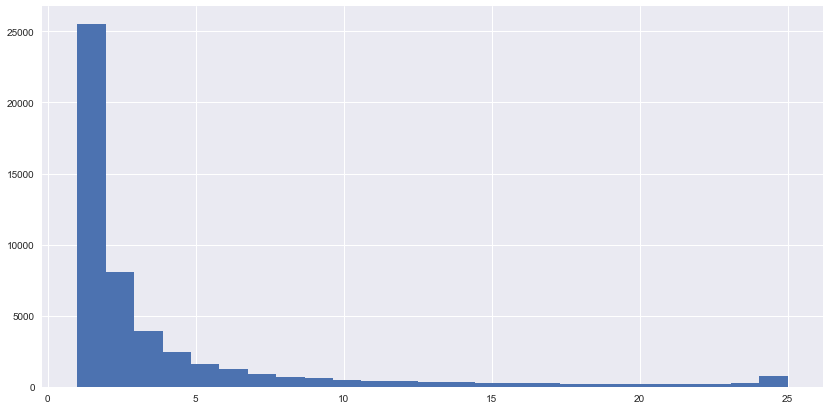

In [170]:
plt.figure(figsize=(14,7))
test_and_pred['comments'].hist(bins=25)

### Evaluating and Auto-Building Best Model

Now that we have a way to serve predictions, we need to make sure that we're actually building the best model possible.

Let's make a train/test split and then evaluate RMSE on different values of k

In [75]:
# to make a test data set, we'll randomly drop 20% of the ratings from the sample dataset.


In [108]:
def build_test_set(df, ratings_column, test_ratio=0.1):
    test_set = df.copy()
    ratings = test_set[ratings_column].values
    # choices == 1 when we are dropping the value, so these are our test cases.
    choices = np.random.choice(a=[0,1], size=len(ratings), p=[1-test_ratio, test_ratio])
    new_ratings = []
    for choice, rating in zip(choices, ratings):
        if choice == 1:
            rating = 0
        new_ratings.append(rating)
    test_set[ratings_column] = new_ratings
    return test_set, choices

In [176]:
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error

k_choices = [5,10,15,20,25,30,40,50]

# we need test cases to know which values were turned to 0
X_train, test_cases = build_test_set(sample, 'comments')

X_train_wide = X_train.pivot(index='user', columns='subreddit', values='comments').fillna(0)
R_train = X_train_wide.as_matrix()
R_train_means = np.mean(R_train, axis = 1)
R_train_demeaned = R_train - R_train_means.reshape(-1,1)

# we'll use this for validation
test_long = sample.copy()
comments_test = test_long.loc[test_cases == 1, 'comments'].values

# let's save the errors for plotting
error_dict = {}

for k in k_choices:
    U, sigma, Vt = svds(R_train_demeaned, k=k)
    sigma = np.diag(sigma)

    # now, to get back to the predicted matrix, we take the dot product of all three matrices, and then add back
    # the means
    R_pred = np.dot(np.dot(U, sigma), Vt) + R_train_means.reshape(-1,1)

    # Taking the wide predictions matrix and turning it into dataframe
    preds_df = pd.DataFrame(R_pred, columns = X_train_wide.columns)    
    
    # adding a username column so that we can melt to long form
    preds_df['user'] = R_df.index
    
    # melting wide dataframe so we can easily compare predicted and test values
    preds_long = pd.melt(preds_df, id_vars='user', value_name='predicted_comments')
    
    # making a test and predicted dataframe that ditches predicted values that weren't in the original data
    test_and_pred = test_long.merge(preds_long, how='left', left_on=['user', 'subreddit'], right_on=['user', 'subreddit'])
    
    # extracting just the predicted comment values
    comments_pred = test_and_pred.loc[test_cases == 1, 'predicted_comments'].values
    
    # calculating root mean squared error
    RMSE = mean_squared_error(comments_test, comments_pred)**0.5
    print "K-Value: ", k
    print "RMSE :", RMSE
    error_dict[k] = RMSE

K-Value:  5
RMSE : 6.57239813331
K-Value:  10
RMSE : 6.57143135907
K-Value:  15
RMSE : 6.57094005986
K-Value:  20
RMSE : 6.56495414718
K-Value:  25
RMSE : 6.56401400585
K-Value:  30
RMSE : 6.56389068747
K-Value:  40
RMSE : 6.56498329581
K-Value:  50
RMSE : 6.56531892329


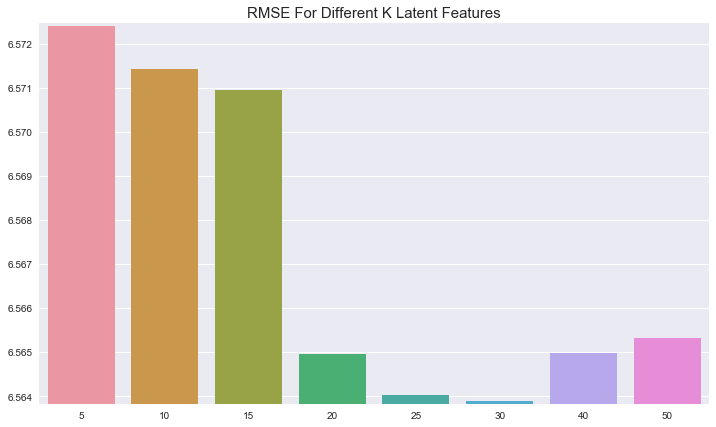

In [177]:
# let's plot out the performance here.
plt.figure(figsize=(12,7))
sns.barplot(x=error_dict.keys(), y=error_dict.values())
plt.ylim(min(error_dict.values())*.99999, max(error_dict.values())*1.00001)
plt.title("RMSE For Different K Latent Features", size=15)